**Лабораторная работа №10. Обработка голоса**

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

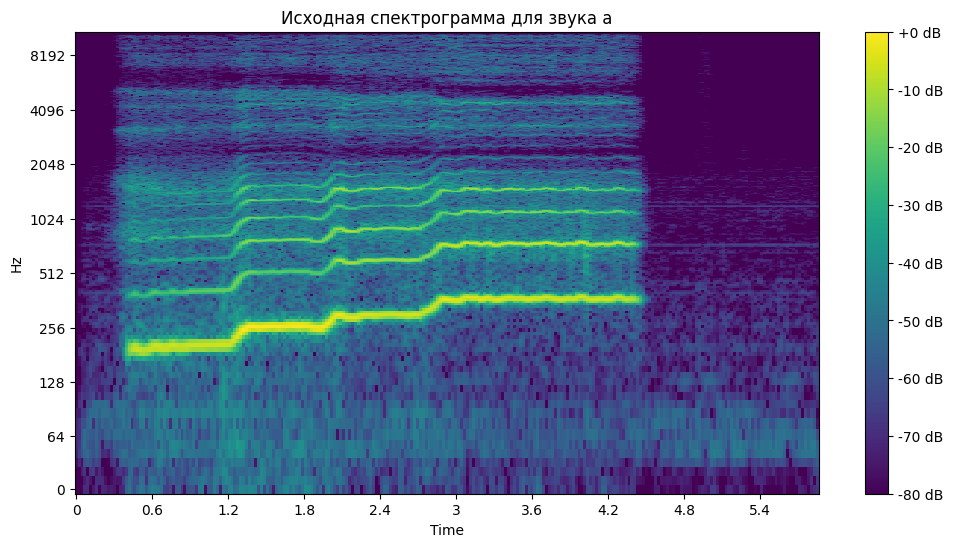

Минимальная частота голоса: 0.0 Гц
Максимальная частота голоса: 10669.7021484375 Гц
Основной тон: 258.3984375 Гц


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


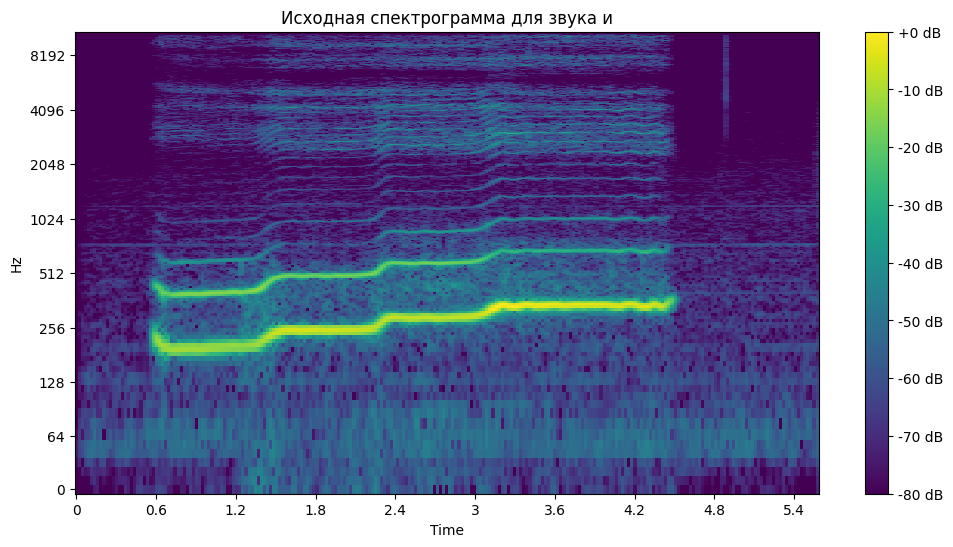

Минимальная частота голоса: 0.0 Гц
Максимальная частота голоса: 10605.1025390625 Гц
Основной тон: 333.7646484375 Гц


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


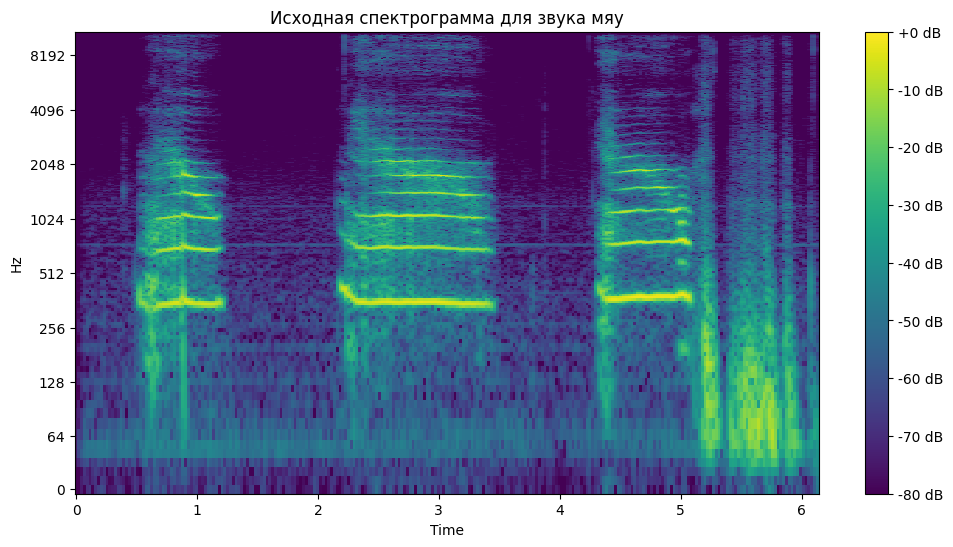

Минимальная частота голоса: 0.0 Гц
Максимальная частота голоса: 10615.869140625 Гц
Основной тон: 1776.4892578125 Гц


In [2]:
def get_spectrogram(audio_data, sample_rate):
    n_fft = 2048
    hop_length = 512
    window = np.hanning(n_fft)
    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length, window=window)
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
    return log_spectrogram, sample_rate, n_fft

def plot_spectrogram(log_spectrogram, sample_rate, n_fft, title):
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

def get_voice_freq_range(log_spectrogram, sample_rate, n_fft):
    min_freq = np.min(np.where(log_spectrogram > -60)[0])
    max_freq = np.max(np.where(log_spectrogram > -60)[0])
    min_freq_hz = min_freq * sample_rate / n_fft
    max_freq_hz = max_freq * sample_rate / n_fft
    return min_freq_hz, max_freq_hz

def get_fundamental_freq(log_spectrogram, sample_rate, n_fft):
    harmonic_product_spectrum = np.prod(log_spectrogram, axis=1)
    fundamental_freq = np.argmax(harmonic_product_spectrum) * sample_rate / n_fft
    return fundamental_freq

def get_formants(log_spectrogram, sample_rate, n_fft):
    time_step = int(0.1 * sample_rate / 512)  # Шаг по времени в индексах
    freq_step = 10  # Шаг по частоте в Гц

    # Разбиение на временные сегменты
    time_slices = range(0, log_spectrogram.shape[1], time_step)
    formants = []
    for j in range(len(time_slices) - 1):
        start = time_slices[j]
        end = time_slices[j + 1]
        segment = log_spectrogram[:, start:end]

        # Поиск трех пиков с наибольшей энергией в сегменте
        freq_bins = np.arange(segment.shape[0]) * sample_rate / n_fft
        peaks = np.argsort(np.max(segment, axis=1))[-3:]
        formants.append([freq_bins[peak] for peak in peaks])

    return formants


def main():
    name_filename = ["a.wav", "i.wav", "meow.wav"]
    name_filename_1 = ["звука а", "звука и", "звука мяу"]

    for i in range(len(name_filename)):
        filename = name_filename[i]
        audio_data, sample_rate = librosa.load(filename)

        # Параметры Фурье
        n_fft = 2048
        hop_length = 512
        window = np.hanning(n_fft)


        # Вычисление спектрограммы
        stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length, window=window)
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

        # Исходная спектрограмма
        log_spectrogram, sample_rate, n_fft = get_spectrogram(audio_data, sample_rate)

        # Исходная спектрограмма
        plot_spectrogram(log_spectrogram, sample_rate, n_fft, f'Исходная спектрограмма для {name_filename_1[i]}')

        # Мин и макс частоты голоса
        min_freq, max_freq = get_voice_freq_range(log_spectrogram, sample_rate, n_fft)
        print(f"Минимальная частота голоса: {min_freq} Гц")
        print(f"Максимальная частота голоса: {max_freq} Гц")

        # Основной тон
        fundamental_freq = get_fundamental_freq(log_spectrogram, sample_rate, n_fft)
        print(f"Основной тон: {fundamental_freq} Гц")

        # Три форманты
        formants = get_formants(log_spectrogram, sample_rate, n_fft)

        with open(f"{filename[:-4]}_results.txt", "w", encoding="utf-8") as f:
          f.write(f"Результаты анализа звукового файла: {filename}\n\n")

          f.write(f"Минимальная частота голоса: {min_freq} Гц\n")
          f.write(f"Максимальная частота голоса: {max_freq} Гц\n\n")

          f.write(f"Основной тон: {fundamental_freq} Гц\n\n")

          f.write("Три самые сильные форманты:\n")
          for i, formant in enumerate(formants, start=1):
              f.write(f"{i}. {formant} Гц\n")


if __name__ == "__main__":
    main()